In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path
from scipy.io import loadmat

os.environ["KERAS_BACKEND"] = "jax"
import keras

In [2]:
import numpy as np

def ddt(X, dt, scheme):
    """
    Uses specified difference scheme to approximate dX/dt with uniform time spacing of size dt.
    
    Parameters:
    X (np.array): N-by-K data matrix where each column is the state at one time.
    dt (float): Time step.
    scheme (str): Specifies which scheme is used to approximate time derivative.
    
    Returns:
    tuple: Tuple containing:
        - np.array: N-by-M data matrix of state time derivatives.
        - np.array: M-by-1 vector of indices of state data in X.
    """
    
    N, K = X.shape

    if scheme in [1, 'FE']:  # Forward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(K - 1)
    elif scheme == 'BE':  # Backward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(1, K)
    elif scheme in [2, '2c']:  # 2nd order central differencing
        dXdt = (X[:, 2:] - X[:, :-2]) / (2 * dt)
        ind = np.arange(1, K - 1)
    elif scheme == '2imp':  # 2nd order backward differencing (implicit)
        dXdt = (3 * X[:, 2:] - 4 * X[:, 1:-1] + X[:, :-2]) / (2 * dt)
        ind = np.arange(2, K)
    elif scheme == '2ex':  # 2nd order forward differencing (explicit)
        dXdt = (-3 * X[:, :-2] + 4 * X[:, 1:-1] - X[:, 2:]) / (2 * dt)
        ind = np.arange(K - 2)
    elif scheme in [4, '4c']:  # 4th order central differencing
        dXdt = (X[:, :-4] - 8 * X[:, 1:-3] + 8 * X[:, 3:-1] - X[:, 4:]) / (12 * dt)
        ind = np.arange(2, K - 2)
    elif scheme == '4imp':  # 4th order backward differencing
        dXdt = (25 / 12 * X[:, 4:] - 4 * X[:, 3:-1] + 3 * X[:, 2:-2] - 4 / 3 * X[:, 1:-3] + 1 / 4 * X[:, :-4]) / dt
        ind = np.arange(4, K)
    elif scheme == '4ex':  # 4th order forward differencing
        dXdt = (-25 / 12 * X[:, :-4] + 4 * X[:, 1:-3] - 3 * X[:, 2:-2] + 4 / 3 * X[:, 3:-1] - 1 / 4 * X[:, 4:]) / dt
        ind = np.arange(K - 4)
    else:
        raise ValueError('Specified difference scheme not implemented')

    return dXdt, ind

# Note: Function calls are commented out to adhere to instructions. They should be uncommented for testing purposes.
# Example of function call (commented out):
# X = np.random.rand(10, 5)  # Example


In [3]:
mus = [0.05]

if len(mus) == 1:
    mu_start = mus[0]
    mu_end = mus[0]
    mu_step = 0
else:
    mu_start = mus[0]
    mu_end = mus[-1]
    mu_step = mus[1] - mus[0]

In [4]:
# Load Burgers data
import json

datapath = '/data1/jy384/research/Data/UnimodalSROB/Burgers/'
srcpath = '/home/jy384/projects/UnimodalSROB/examples/burgers/'

snapshots_path = Path(datapath) / 'snapshots'
X_all_files = list(Path(datapath).rglob(f'X_all_mu_*'))
if X_all_files:
    for file in X_all_files:
        if str(mu_start) + '_' in file.name and str(mu_end) in file.name and str(mu_step) + '_' in file.name:
            print(file)
            X_all = loadmat(file)['X_all']
            
# load trajectory data
trajectories_path = Path(datapath) / 'trajectories'

# Find the files 
U_all_files = list(Path(datapath).rglob(f'U_all_mu_*'))

# Load the data with the mu_start, mu_end, and mu_step in their names
if U_all_files:
    for file in U_all_files:
        if str(mu_start) + '_' in file.name and str(mu_end) in file.name and str(mu_step) + '_' in file.name:
            print(file)
            U_all = loadmat(file)['U_all']
            
print("Shape of U_all: ", U_all.shape)

/data1/jy384/research/Data/UnimodalSROB/Burgers/snapshots/X_all_mu_0.05_0_0.05.mat
/data1/jy384/research/Data/UnimodalSROB/Burgers/trajectories/U_all_mu_0.05_0_0.05.mat
Shape of U_all:  (99980, 1)


In [5]:
# Convert cell arrays to numpy arrays for X_all and R_all
X_all = np.array([X_all[0][i] for i in range(X_all.shape[1])])

print("Shape of X_all: ", X_all.shape)

Shape of X_all:  (1, 129, 99980)


X =  (129, 99980)
X_ref =  (129, 1)
S =  [322.35553604  84.10572023  75.08670598  30.05862807  18.11647143]
idx =  8
rel_err_SVD[idx] =  3.2328971631967462e-06


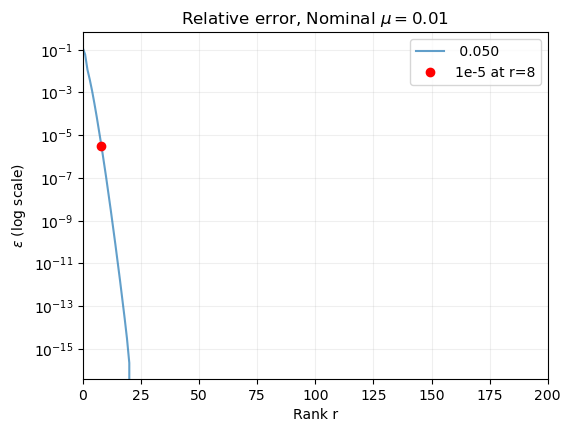

In [6]:
rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
names = [f'{mu: .3f}' for mu in mus]

fig, ax = plt.subplots(figsize=(6, 4.5))

err_tol = 1e-5

# mus = [0.01] # only one mu for now

for i in range(len(mus)):
    
    X = X_all[i, :, :] # only one mu for now
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    X_ref = np.mean(X, axis=1)[:, None]
    
    print("X = ", X.shape)
    print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0]
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"1e-5 at r={idx}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.set_title("Relative error, Nominal $\mu = 0.01$")
    ax.legend()

In [7]:
# find the idx where 98% of the energy is captured
np.where(rel_err_SVD < 1e-3)[0][0]

5

In [8]:
r = 15
p = 15

V = rob_lst[0][:, :r]
Vbar = rob_lst[0][:, r:r+p]


In [9]:
X = X_all[0, :, :]
U_input = U_all[:, 0][:, None] # only one mu for now
# X_ref = np.mean(X, axis=1)[:, None]
X_ref = np.zeros((X.shape[0], 1))
q = V.T @ (X - X_ref)
qbar = Vbar.T @ (X - X_ref)

print("q = ", q.shape)
print("qbar = ", qbar.shape)


q =  (15, 99980)
qbar =  (15, 99980)


In [10]:
# simple neural network to learn X = X_ref + V.T @ q + Vbar @ qbar where q is the latent variable and qbar is the latent variable associated with nonlinearity
# qbar = NN(q), therefore we need to minimize the loss function ||X - X_ref - V.T @ q - Vbar @ NN(q)||^2

# define the neural network Keras model with 5 layers
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

hidden_size = 50
# define the input layer
input_layer = Input(shape=(r,))
# define the hidden layers,  neural network Keras model with 5 layers
hidden_layer_1 = Dense(hidden_size, activation='silu')(input_layer)
hidden_layer_2 = Dense(hidden_size, activation='silu')(hidden_layer_1)
hidden_layer_3 = Dense(hidden_size, activation='silu')(hidden_layer_2)
hidden_layer_4 = Dense(hidden_size, activation='silu')(hidden_layer_3)
hidden_layer_5 = Dense(hidden_size, activation='silu')(hidden_layer_4)
# define the output layer
output_layer = Dense(qbar.shape[0], activation='linear')(hidden_layer_5)
# define the model
model = Model(input_layer, output_layer)
# compile the model



In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,765 (45.96 KB)

 Trainable params: 11,765 (45.96 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
qbar.T.shape

(99980, 15)

Epoch 1/2000


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 584.7827 - relative_err_metric: 584.7812 - val_loss: 93.4243 - val_relative_err_metric: 92.8724 - learning_rate: 0.0010
Epoch 2/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 99.0815 - relative_err_metric: 99.0818 - val_loss: 98.4272 - val_relative_err_metric: 97.7540 - learning_rate: 0.0010
Epoch 3/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 77.3255 - relative_err_metric: 77.3251 - val_loss: 63.2932 - val_relative_err_metric: 62.8484 - learning_rate: 0.0010
Epoch 4/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 62.1703 - relative_err_metric: 62.1703 - val_loss: 66.3113 - val_relative_err_metric: 65.8636 - learning_rate: 0.0010
Epoch 5/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 55.1547 - relative_err_metric: 55.1550 - val_loss: 66.4840 - val_relative_err_metric: 66.0890 - learning_rate: 0.0010
Epoch 6/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 52.2193 - relative_err_metric: 52.2190 

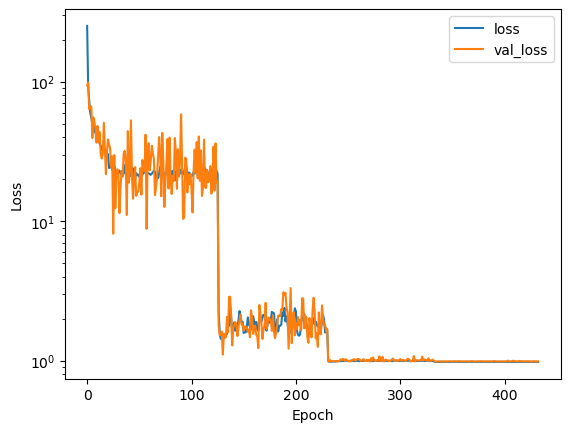

In [13]:
# define custom metric as relative norm error ||y_true - y_pred|| / ||y_true||
def relative_err_metric(y_true, y_pred):
    # return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true), axis=[0, 1])) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true), axis=[0, 1]))
    return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true)))
    # return keras.ops.linalg.norm(y_pred - y_true, ord=2) / keras.ops.linalg.norm(y_true, ord=2)


def relative_err_loss(y_true, y_pred):
    # return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true), axis=[0, 1])) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true), axis=[0, 1]))
    return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true)))
    # return keras.ops.linalg.norm(y_pred - y_true, ord=2) / keras.ops.linalg.norm(y_true, ord=2)



# define the loss function
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=relative_err_loss,
              metrics=[relative_err_metric])
# train the model with loss visualization

batch_size = 256
epochs = 2000

callbacks = [
    # keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras", save_best_only=True, monitor="val_loss", verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=200),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=100, min_lr=1e-6)
]


history = model.fit(q.T, qbar.T,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=callbacks)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()



In [14]:
# calculate reconstruction error
qbar_pred = model.predict(q.T).T
X_pred = X_ref + V @ q + Vbar @ qbar_pred
reconstruction_error = np.linalg.norm(X - X_pred) / np.linalg.norm(X)
print("reconstruction_error = ", reconstruction_error)

 340/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 148us/step 

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 159us/step
reconstruction_error =  3.0709164554412726e-06


In [15]:
import opinf


# preprocess data
Mp = 10 # number of different input trajectories
N = int(X.shape[1]/Mp) # number of snapshots per trajectory
dt = 1e-4 # time step

print("N = ", N)

qdot_lst = []
q_lst = []
U_lst = []
# get derivative estimates
for n_traj in range(Mp):
    # qdot_lst.append(opinf.ddt.ddt(q[:, n_traj*N:(n_traj+1)*N], dt=dt, order=2))
    qdot, ind = ddt(q[:, n_traj*N:(n_traj+1)*N], dt=dt, scheme='2imp')
    qdot_lst.append(qdot)
    q_lst.append(q[:, ind + n_traj*N])
    U_lst.append(U_input[ind + n_traj*N])
    
    
    
qdot = np.concatenate(qdot_lst, axis=1)
q = np.concatenate(q_lst, axis=1)
U_input = np.concatenate(U_lst, axis=0)

# qdot = opinf.ddt.ddt(q, dt=dt, order=6)

# qdot = opinf.ddt.ddt((X - X_ref), dt=dt, order=6).T @ V
# qdot = qdot.T

N =  9998


In [16]:
print("qdot = ", qdot.shape)
print("q = ", q.shape)
print("U_input = ", U_input.shape)

qdot =  (15, 99960)
q =  (15, 99960)
U_input =  (99960, 1)


In [17]:
# coordinates are equally spaced points from 0 to 1 with 2^7 + 1 points
coord = np.linspace(0, 1, 2**7 + 1)
print("coord = ", coord.shape)

coord =  (129,)


In [18]:
projected_coord = V.T @ coord
projected_coord = projected_coord[:, None]
print("projected_coord = ", projected_coord.shape)

projected_coord =  (15, 1)


In [19]:
q.shape

(15, 99960)

In [20]:
# construct input data by concatenating q and trajectory data
# Time = np.repeat(np.linspace(0, 1, N), Mp)[:, None]
# Time_lst = []
# for n_traj in range(Mp):
#     Time_lst.append(Time[n_traj*N:(n_traj+1)*N])
    
# Time = np.concatenate(Time_lst, axis=0)

# print(Time)
print("U_input = ", U_input.shape)
# input_data = np.hstack((q.T, U_input, Time))
input_data = np.hstack((q.T, U_input))
# input_data = q.T
print("input_data = ", input_data.shape)

U_input =  (99960, 1)
input_data =  (99960, 16)


Epoch 1/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5785 - relative_err_metric_opinf: 0.5785 - val_loss: 0.1599 - val_relative_err_metric_opinf: 0.1599 - learning_rate: 0.0100
Epoch 2/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.1826 - relative_err_metric_opinf: 0.1826 - val_loss: 0.2253 - val_relative_err_metric_opinf: 0.2251 - learning_rate: 0.0100
Epoch 3/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 0.1725 - relative_err_metric_opinf: 0.1725 - val_loss: 0.1950 - val_relative_err_metric_opinf: 0.1947 - learning_rate: 0.0100
Epoch 4/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.1548 - relative_err_metric_opinf: 0.1548 - val_loss: 0.1416 - val_relative_err_metric_opinf: 0.1415 - learning_rate: 0.0100
Epoch 5/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.1448 - relative_err_metric_opinf: 0.1448 - val_loss: 0.1617 - val_relative_err_metric_opinf: 0.1618 - learning_rate: 0.0100
Epoch 6/2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/s

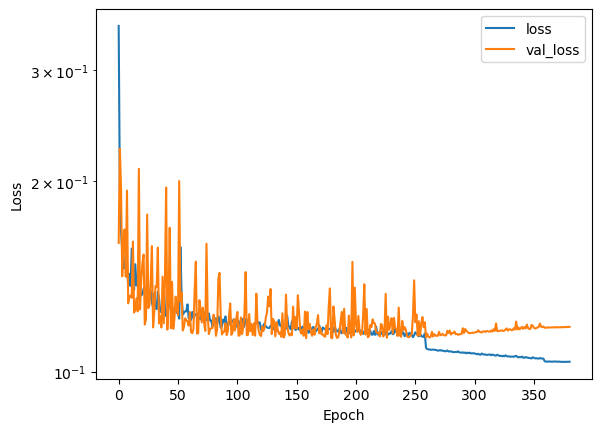

In [21]:
# construct Neural Network model for operator inference
input_layer_opinf = Input(shape=(input_data.shape[1],))
hidden_size_opinf = 256
epochs = 2000
# input_layer_opinf = Input(shape=(r,))
hidden_layer_opinf_1 = Dense(hidden_size_opinf, activation='silu')(input_layer_opinf)
hidden_layer_opinf_2 = Dense(hidden_size_opinf, activation='silu')(hidden_layer_opinf_1)
hidden_layer_opinf_3 = Dense(hidden_size_opinf, activation='silu')(hidden_layer_opinf_2)
hidden_layer_opinf_4 = Dense(hidden_size_opinf, activation='silu')(hidden_layer_opinf_3)
hidden_layer_opinf_5 = Dense(hidden_size_opinf, activation='silu')(hidden_layer_opinf_4)
output_layer_opinf = Dense(qdot.shape[0], activation='linear')(hidden_layer_opinf_5)


callbacks_opinf = [
    # keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras", save_best_only=True, monitor="val_loss", verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=200),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=100, min_lr=1e-6)
]


batch_size_opinf = 256



def relative_err_loss_opinf(y_true, y_pred):
    return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true)))
    # return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true)))

def relative_err_metric_opinf(y_true, y_pred):
    return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true)))
    # return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) 

model_opinf = Model(input_layer_opinf, output_layer_opinf)
model_opinf.compile(optimizer=Adam(learning_rate=0.01), 
                loss=relative_err_loss_opinf,
                metrics=[relative_err_metric_opinf])

# train the model with loss visualization
history_opinf = model_opinf.fit(input_data, qdot.T,
                    batch_size=batch_size_opinf,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=callbacks_opinf)
plt.plot(history_opinf.history['loss'])
plt.plot(history_opinf.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [1]:
from scipy.optimize import fsolve

# implicit time integration

num_steps = int(1/dt)

# Initialize the solution array
shat = np.zeros((num_steps+1, q.shape[0]))

# Set the initial condition
shat[0] = np.zeros(q.shape[0])

U_pred = np.ones((num_steps, 1))
t_arr = np.linspace(0, 1, num_steps).reshape(-1, 1)
features = np.hstack((U_pred, t_arr))


# def implicit_euler_vector(s_current, u_pred, t, dt, model, max_iter=100):
def implicit_euler_vector(s_current, u_pred, dt, model, max_iter=1000):
# def implicit_euler_vector(s_current, dt, model, max_iter=100):    
    """ Implicit Euler integrator for a state vector using a neural network model.

    Args:
    s_current (np.array): Current state vector \hat{s}(t).
    dt (float): Time step size \Delta t.
    model (keras.Model): The neural network model representing d\hat{s}/dt.
    max_iter (int): Maximum number of iterations for the solver.

    Returns:
    np.array: Updated state vector \hat{s}(t + \Delta t).
    """
    # input = np.hstack((s_current.reshape(1, -1), u_pred.reshape(1, -1), np.array(t).reshape(1, -1)))
    input = np.hstack((s_current.reshape(1, -1), u_pred.reshape(1, -1)))
    def func(s_next, input):
        # return s_current + dt * model.predict(input, verbose=0)[0] - s_next
        return s_current + dt * model.predict(input, verbose=0)[0] - s_next
        # return s_current + dt * model.predict(np.array([s_next]), verbose=0)[0] - s_next

    # Initial guess for fsolve is the current state
    s_next = fsolve(func, s_current, args=[input], xtol=1e-5, maxfev=max_iter)
    # s_next = fsolve(func, s_current, xtol=1e-5, maxfev=max_iter)
    return s_next


def rk4(s_current, dt, nn_model):
    """ Runge-Kutta 4th order integration for neural network dynamics.

    Args:
    s_current (np.array): Current state at time step t.
    dt (float): Time step size.
    nn_model (callable): Neural network model function that predicts the derivative.
    
    Returns:
    np.array: Updated state at time step t + dt.
    """
    # k1 = dt * nn_model.predict(np.array([s_current]))[0]
    # k2 = dt * nn_model.predict(np.array([s_current + 0.5 * k1]))[0]
    # k3 = dt * nn_model.predict(np.array([s_current + 0.5 * k2]))[0]
    # k4 = dt * nn_model.predict(np.array([s_current + k3]))[0]
    # s_next = s_current + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    k1 = dt * nn_model.predict(np.array(s_current), verbose=0)[0]
    k1_ = np.hstack((k1.reshape(1, -1), s_current[:, k1.shape[0]:]))
    
    k2 = dt * nn_model.predict(np.array(s_current + 0.5 * k1_), verbose=0)[0]
    k2_ = np.hstack((k2.reshape(1, -1), s_current[:, k2.shape[0]:]))
    
    k3 = dt * nn_model.predict(np.array(s_current + 0.5 * k2_), verbose=0)[0]
    k3_ = np.hstack((k3.reshape(1, -1), s_current[:, k3.shape[0]:]))
    
    k4 = dt * nn_model.predict(np.array(s_current + k3_), verbose=0)[0]
    # k4 = np.hstack((k4.reshape(1, -1), s_current[:, k4.shape[0]:]))
    
    s_next = s_current.flatten()[:k1.shape[0]] + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return s_next


# Run the implicit Euler integration
for i in range(1, num_steps):
    t_ = (i-1) * dt
    # shat[i] = implicit_euler_vector(shat[i-1], U_pred[i-1], t_, dt, model=model_opinf)
    shat[i] = implicit_euler_vector(shat[i-1], U_pred[i-1], dt, model=model_opinf)
    # shat[i] = implicit_euler_vector(shat[i-1], dt, model=model_opinf)

# Optionally, print or plot the results
print(shat)

# # rk4
# for i in range(num_steps):
#     input = np.hstack((shat[i].reshape(1, -1), U_pred[i].reshape(1, -1)))
#     shat[i+1] = rk4(input, dt, model_opinf)
    

# Optionally, print or plot the results
print(shat)


# # Perform the time integration
# for i in range(1, num_steps):
#     t = i * dt
    
#     print(shat[i-1].shape)
#     print(features[i].reshape(1, -1).shape)
    
#     input = np.hstack((shat[i-1].reshape(1, -1), features[i].reshape(1, -1)))
    
#     print(input.shape)
    
#     # Compute the right-hand side of the implicit equation
#     rhs = shat[i-1] + dt * model_opinf.predict(input)
    
#     # Solve the implicit equation using a numerical solver
#     shat[i] = np.linalg.solve(np.eye(len(coord)) - dt * model_opinf.predict()


NameError: name 'dt' is not defined

In [35]:
model.predict(shat).shape

  1/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


(10001, 15)

In [36]:
s_recon = X_ref + V @ shat.T + Vbar @ model.predict(shat).T

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


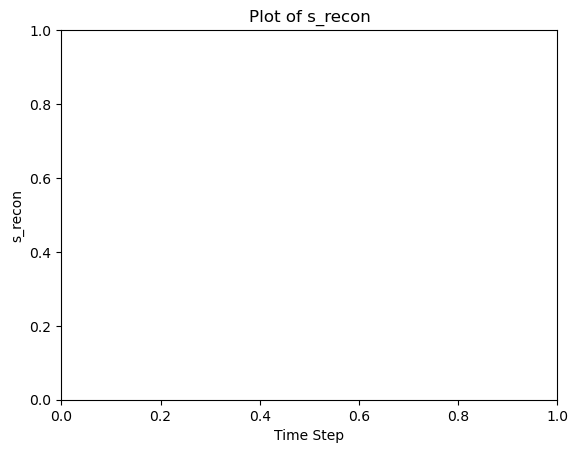

In [37]:
import matplotlib.pyplot as plt

plt.imshow(s_recon, aspect="auto", extent=[0, 1, 0, 1])
plt.xlabel('Time Step')
plt.ylabel('s_recon')
plt.title('Plot of s_recon')
plt.show()
